# **Dataset Overview: Human Organoids Study**

## **Data Description**
In this analysis, we will work with **human organoid** data obtained from the **GEO database**. The dataset provides transcriptomic information from **wild-type (WT) human organoids**, allowing us to study gene expression patterns and network interactions.

## **Dataset Details**
| **Attribute** | **Details** |
|--------------|------------|
| **Source Name** | Human organoids |
| **Organism** | *Homo sapiens* |
| **Characteristics** | Tissue: Human organoids |
|  | Genotype: Wild-type (WT) |

This dataset is available from the **GEO repository** at the following link:  
[**GSM7732411 - GEO Accession**](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM7732411)

## **Objective of the Analysis**
- Explore **gene expression patterns** in human organoids.  
- Construct and analyze **biological networks** from differentially expressed genes.  
- Identify key **functional pathways** and interactions.
- Prepare data for ensuing **perturbation modelling** to discover potentially druggable targets related to Parkinsons (PD)  

This study provides insights into **wild-type human organoids**, which serve as a model for understanding **cellular differentiation, disease mechanisms, and therapeutic applications**.

# Dependencies

In [136]:
pip install --upgrade scanpy

Note: you may need to restart the kernel to use updated packages.


In [137]:
# Core scverse libraries
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

In [138]:
!pwd

/home/g0bi/g0bi/GenKI/notebook


# Data Preprocessing

## Loading in Scanpy

In [139]:
# Load data into Scanpy

In [140]:
import pandas as pd
genes_path = "../data/organoids/genes.tsv.gz"  # Or features.tsv.gz
genes = pd.read_csv(genes_path, sep='\t', header=None)
print(genes.head())
print(genes.shape)  # Check the number of columns

                 0            1
0  ENSG00000223972      DDX11L1
1  ENSG00000227232       WASH7P
2  ENSG00000278267    MIR6859-1
3  ENSG00000243485  MIR1302-2HG
4  ENSG00000284332    MIR1302-2
(58336, 2)


In [141]:
genes['feature_type'] = 'Gene Expression'
genes.to_csv("../data/organoids/features.tsv.gz", sep='\t', index=False, header=False)

In [142]:
# Path to the folder containing the matrix, barcodes, and genes files
data_folder = "../data/organoids"

# Load the data
adata = sc.read_10x_mtx(
    data_folder,       # Path to the folder containing the files
    var_names='gene_symbols',  # Use gene symbols for variable names
    cache=True         # Cache the result for faster reloading
)

# Inspect the loaded data
print(adata)

AnnData object with n_obs × n_vars = 6009 × 58336
    var: 'gene_ids', 'feature_types'


## QC

In [143]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [144]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

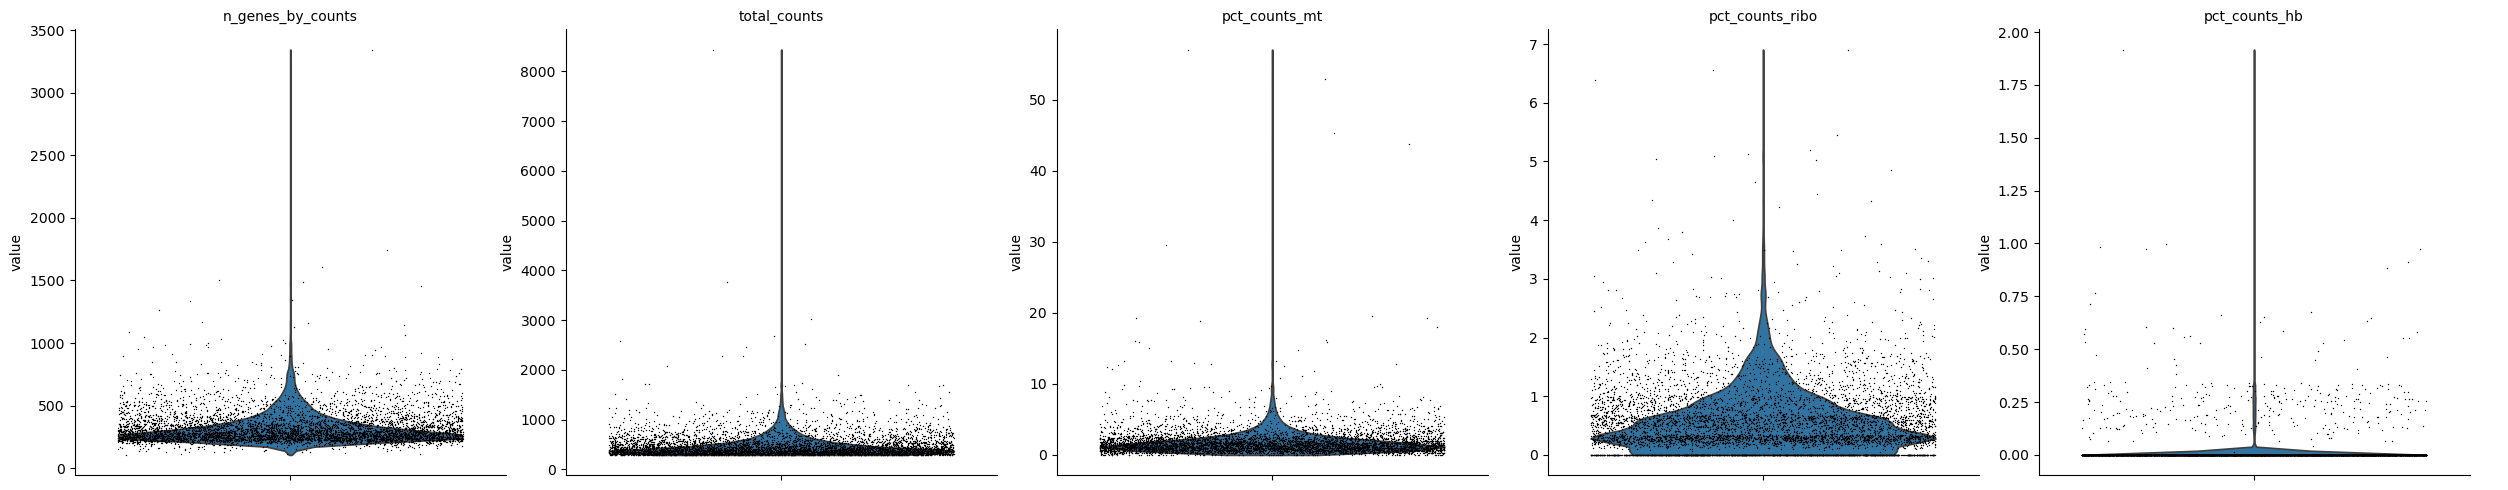

In [145]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    multi_panel=True,
)

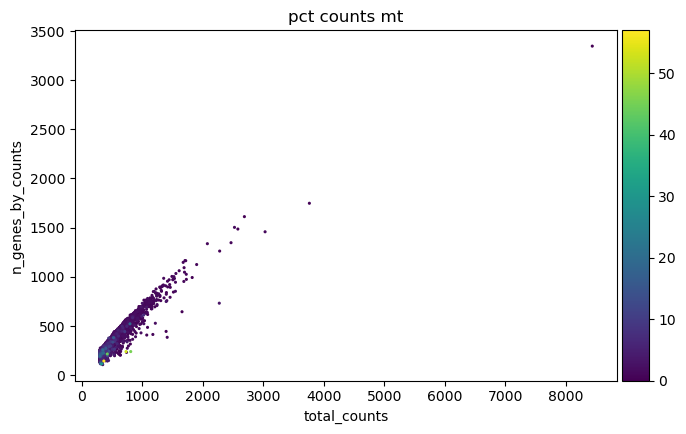

In [146]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [147]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [148]:
adata = adata[adata.obs.n_genes_by_counts < 2000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :].copy()

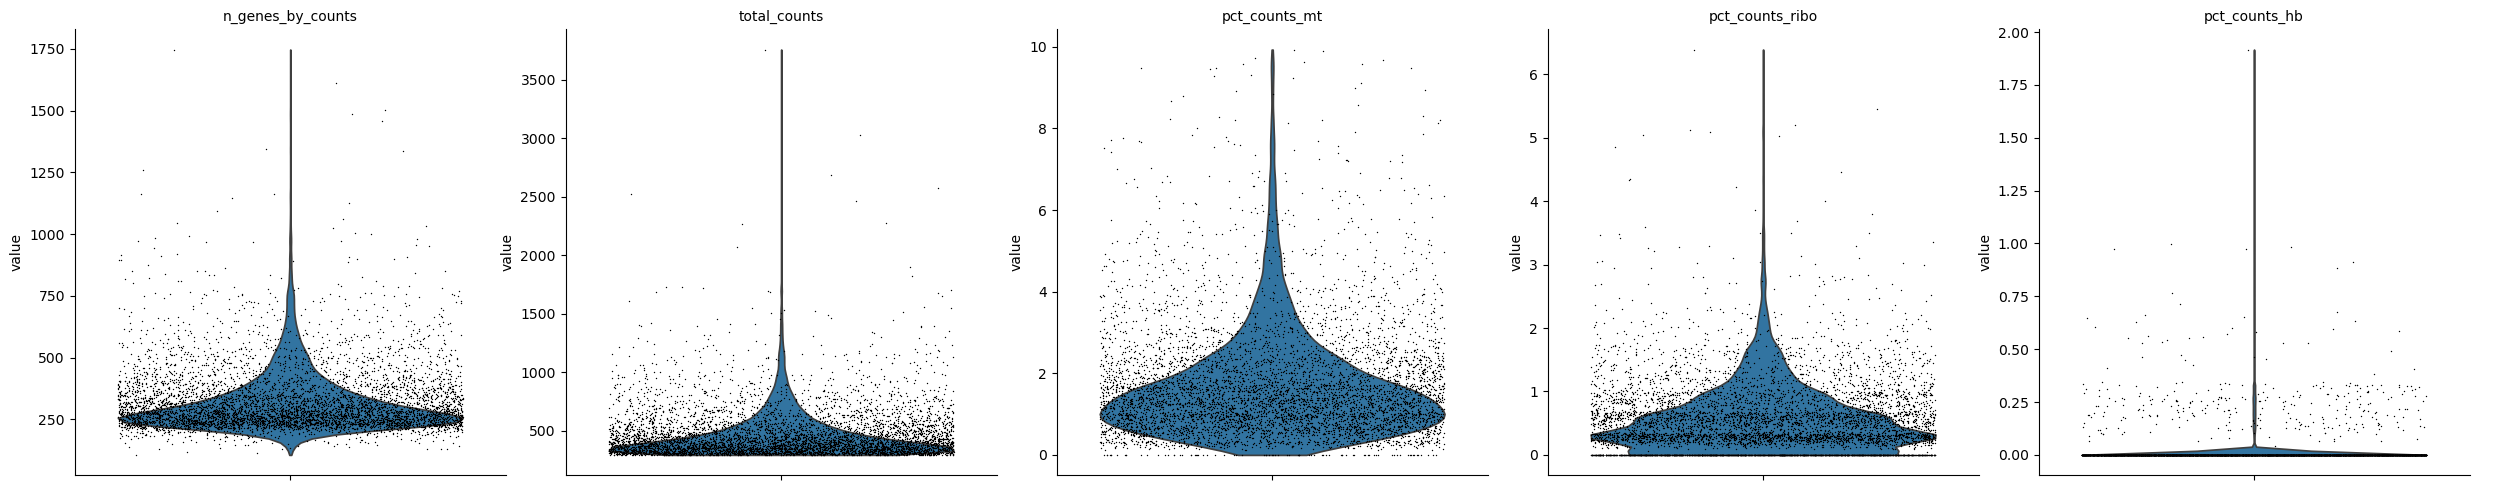

In [149]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    multi_panel=True,
)

## Doublet detection

In [150]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [151]:
sc.pp.scrublet(adata)

## Normalisation

In [152]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [153]:
adata_backup = adata

In [154]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

## Feature Selection

In [155]:
sc.pp.highly_variable_genes(adata, n_top_genes=5000)

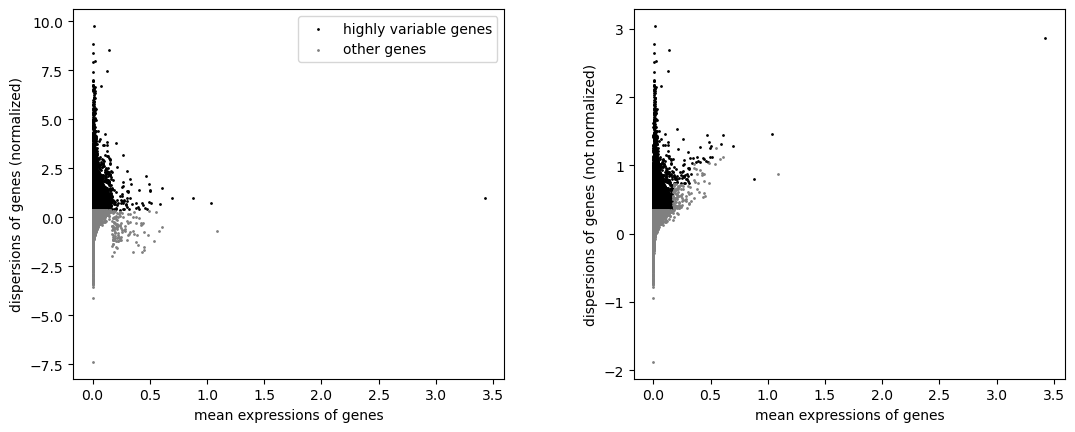

In [156]:
sc.pl.highly_variable_genes(adata)

In [157]:
# List of genes to check
genes_of_interest = ["SIAH1", "SNCA"]

# Check if the `highly_variable` column exists
if 'highly_variable' in adata.var.columns:
    # Subset the DataFrame to the genes of interest
    genes_in_hvg = adata.var.loc[adata.var.index.isin(genes_of_interest) & adata.var['highly_variable']]
    
    # Print the result
    if not genes_in_hvg.empty:
        print("The following genes are in the HVGs:")
        print(genes_in_hvg.index.tolist())
    else:
        print("None of the genes of interest are in the HVGs.")
else:
    print("The HVG information is not available in `adata.var`.")


The following genes are in the HVGs:
['SNCA']


## Dimensionality Reduction

In [158]:
sc.tl.pca(adata)

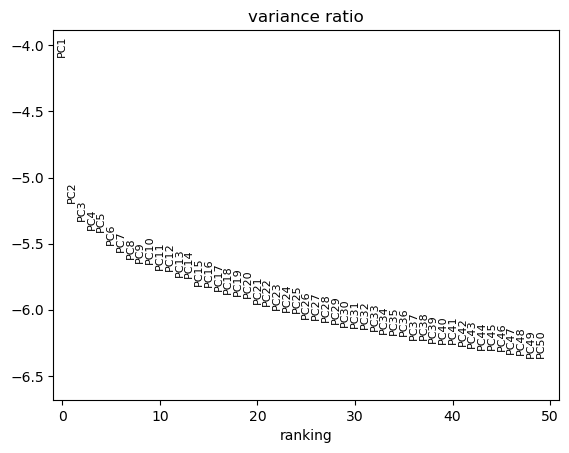

In [159]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

## Nearest neighbor graph constuction, clustering and visualization

In [160]:
sc.pp.neighbors(adata)

In [161]:
sc.tl.umap(adata)

In [162]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

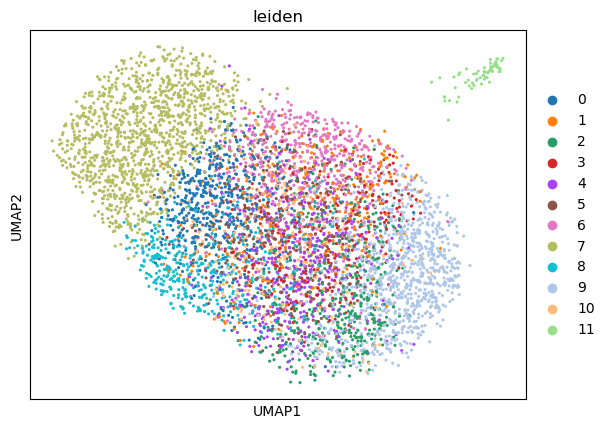

In [163]:
sc.pl.umap(adata, color=["leiden"])

## Re-assess quality control and cell filtering

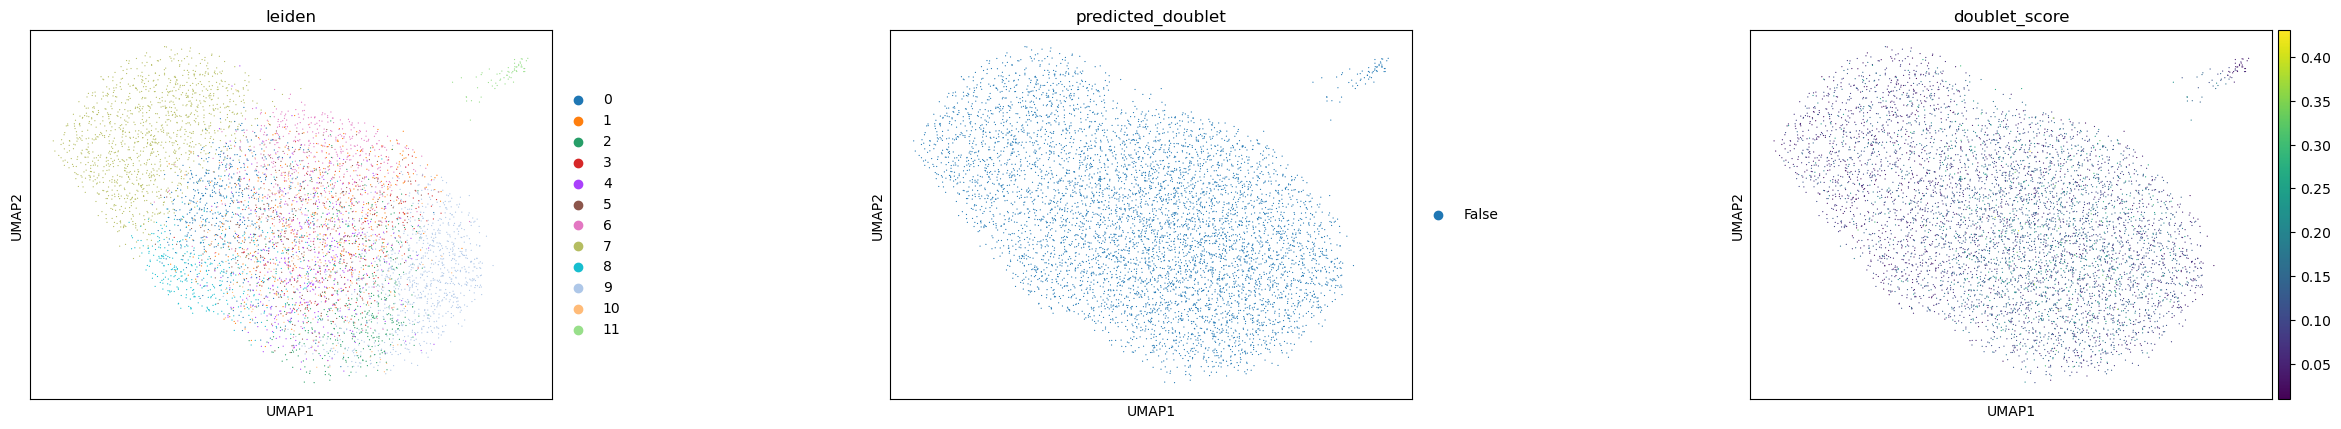

In [164]:
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

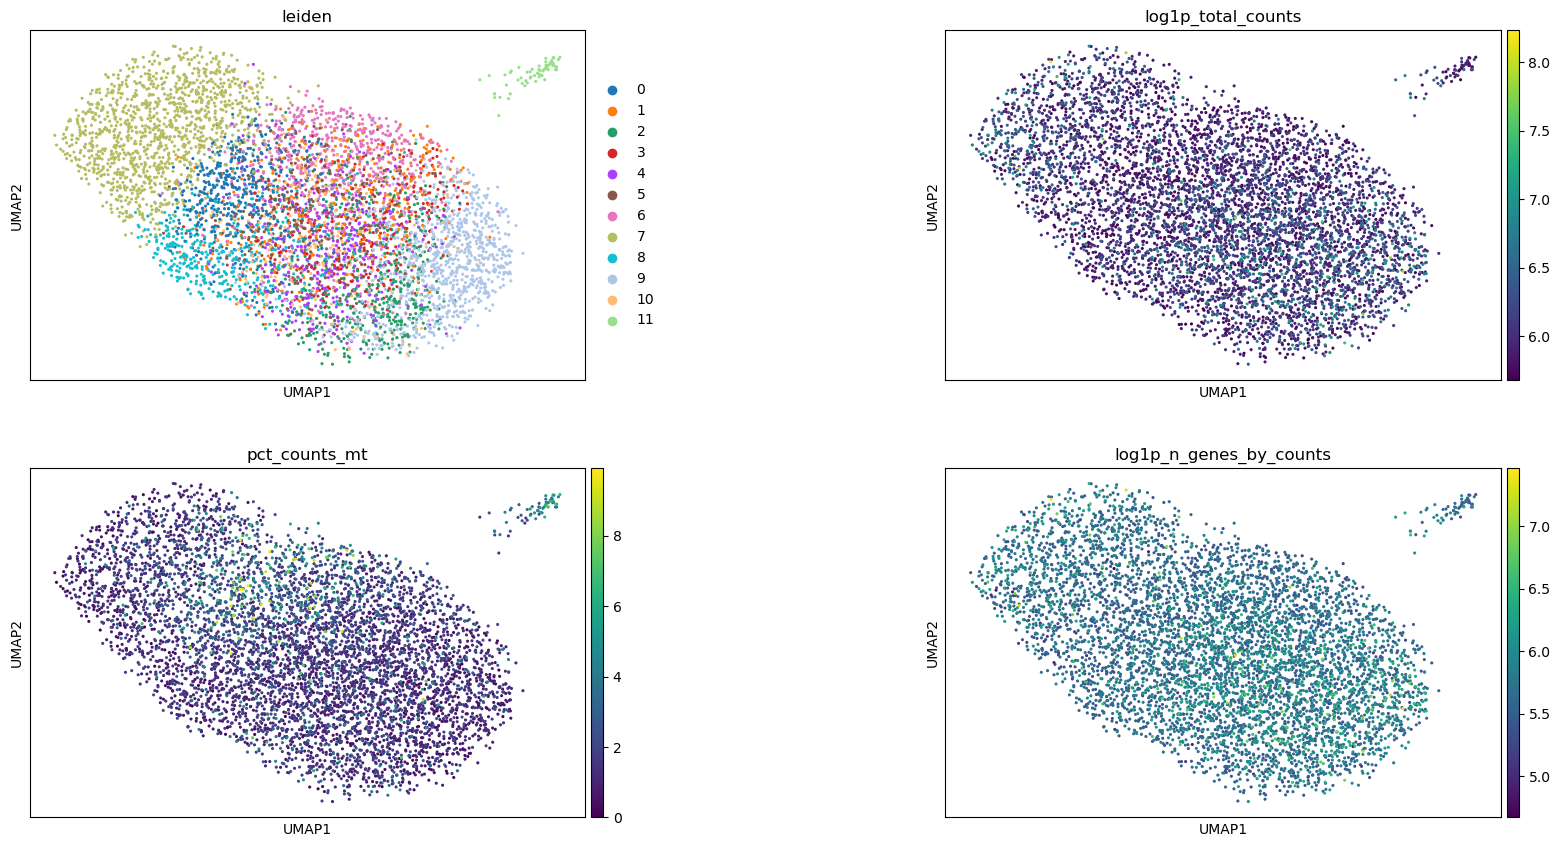

In [165]:
sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

In [166]:
# Check the columns in `adata.obs` for Scrublet results
print(adata.obs.columns)

# Assuming doublet predictions are stored in a column called `predicted_doublet`
if 'predicted_doublet' in adata.obs.columns:
    print("Before filtering:")
    print(adata.shape)  # Print the shape before filtering

    # Remove predicted doublets
    adata = adata[~adata.obs['predicted_doublet']].copy()  # Keep only non-doublets

    print("After filtering:")
    print(adata.shape)  # Print the shape after filtering
else:
    print("No doublet prediction column (`predicted_doublet`) found in `adata.obs`.")

Index(['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb',
       'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score',
       'predicted_doublet', 'leiden'],
      dtype='object')
Before filtering:
(5978, 19193)
After filtering:
(5978, 19193)


In [167]:
adata.obs["predicted_doublet"].unique()

array([False])

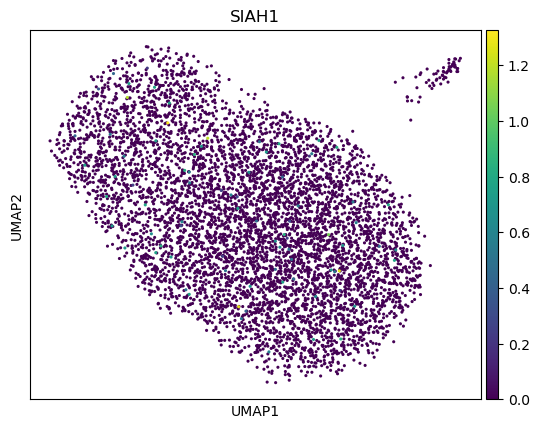

In [168]:
sc.pl.umap(
    adata,
    color=["SIAH1"],
    wspace=0.5,
    ncols=2,
)

## Marker genes

In [169]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

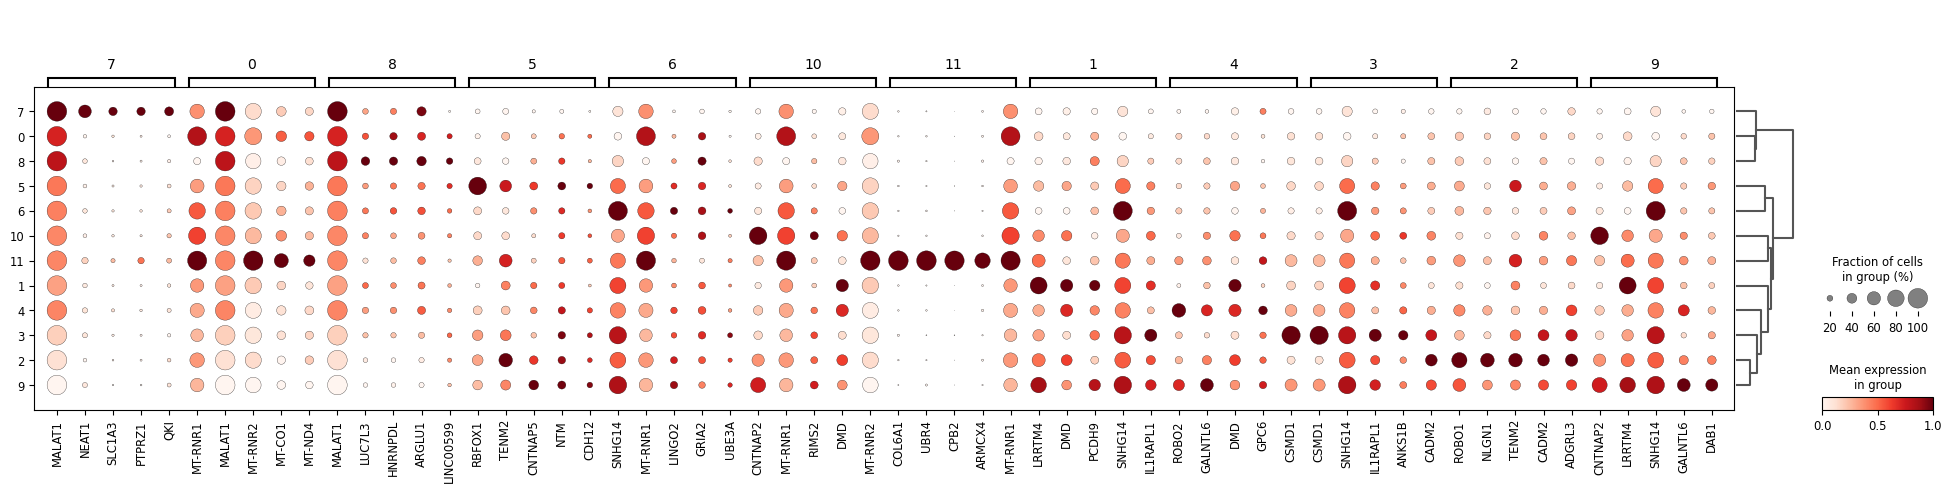

In [170]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=5
)

In [171]:
adata

AnnData object with n_obs × n_vars = 5978 × 19193
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'predicted_doublet_colors', 'rank_genes_groups', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp

## SCTransform

Come here from QC directly!

In [172]:
import scanpy as sc

# Define cell cycle gene lists from Tirosh et al. (2016)
s_genes = [
    "MCM5", "PCNA", "TYMS", "FEN1", "MCM2", "MCM4", "RRM1", "UNG", "GINS2", "MCM6",
    "CDCA7", "DTL", "PRIM1", "UHRF1", "HELLS", "RFC2", "RPA2", "NASP", "RAD51AP1",
    "GMNN", "WDR76", "SLBP", "CCNE2", "UBR7", "POLD3", "MSH2", "ATAD2", "RAD51",
    "RRM2", "CDC45", "CDC6", "EXO1", "TIPIN", "DSCC1", "BLM", "CASP8AP2",
    "USP1", "CLSPN", "POLA1", "CHAF1B", "BRIP1", "E2F8"
]

g2m_genes = [
    "HMGB2", "CDK1", "NUSAP1", "UBE2C", "BIRC5", "TPX2", "TOP2A", "NDC80",
    "CKS2", "NUF2", "CKS1B", "MKI67", "TMPO", "CENPF", "TACC3", "FAM64A",
    "SMC4", "CCNB2", "CKAP2L", "CKAP2", "AURKB", "BUB1", "KIF11", "ANLN",
    "LBR", "CENPE", "CTCF", "G2E3", "GAS2L3", "NCAPG", "HJURP", "ESCO2",
    "SGOL2", "PIMREG", "CDCA3", "HN1", "CDC20", "TTK", "CDC25C", "KIF20B",
    "TFAP2C", "UBE2T"
]

# Make sure genes are present in your dataset
s_genes = [gene for gene in s_genes if gene in adata.var_names]
g2m_genes = [gene for gene in g2m_genes if gene in adata.var_names]

# Compute cell cycle scores
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

# Check the computed cell cycle scores
print(adata.obs[['S_score', 'G2M_score', 'phase']].head())

                              S_score  G2M_score phase
AACACACAGAACGCTAGTACTATCGCC -0.012164  -0.004264    G1
AACACACAGAACGCTAGTCCATCCTAA -0.003592  -0.006102    G1
AACACACAGAACGTCCAACCATCCTAA -0.002592  -0.007339    G1
AACACACAGAACGTCCAACTCTGCTTA -0.005570  -0.005440    G1
AACACACAGAACGTCCAACTGCGTAGT -0.003416   0.008461   G2M


In [173]:
for adata in [adata]:
    sc.experimental.pp.highly_variable_genes(
        adata, flavor="pearson_residuals", n_top_genes=5000
    )

/home/g0bi/conda/envs/ogenki/lib/python3.11/site-packages/scanpy/experimental/pp/_highly_variable_genes.py:154: UserWarning: `flavor='pearson_residuals'` expects raw count data, but non-integers were found.
  warnings.warn(


/home/g0bi/conda/envs/ogenki/lib/python3.11/site-packages/scanpy/experimental/pp/_highly_variable_genes.py:154: UserWarning: `flavor='pearson_residuals'` expects raw count data, but non-integers were found.
  warnings.warn(


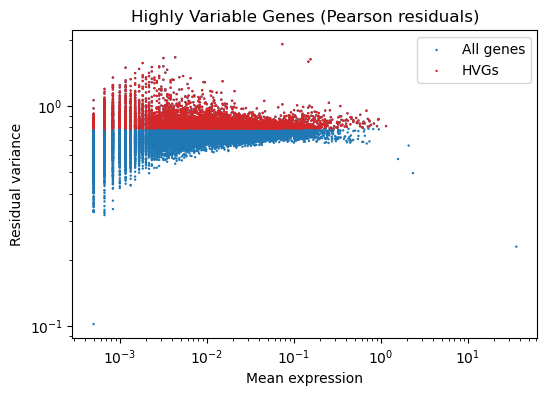

In [174]:
# Compute highly variable genes using Pearson residuals
for adata in [adata]:
    sc.experimental.pp.highly_variable_genes(
        adata, flavor="pearson_residuals", n_top_genes=5000
    )

# Extract data
mean_counts = adata.var["mean_counts"]
residual_variances = adata.var["residual_variances"]
hvgs = adata.var["highly_variable"]

# Create scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(mean_counts, residual_variances, s=3, edgecolor="none", label="All genes")
plt.scatter(mean_counts[hvgs], residual_variances[hvgs], c="tab:red", s=3, edgecolor="none", label="HVGs")

# Log scales & labels
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean expression")
plt.ylabel("Residual variance")
plt.title("Highly Variable Genes (Pearson residuals)")
plt.legend()
plt.show()

In [175]:
import scanpy as sc
import numpy as np

# Store raw counts before normalization
adata.layers["raw"] = adata.X.copy()

# Apply total-count normalization and square-root transform
adata.layers["sqrt_norm"] = np.sqrt(sc.pp.normalize_total(adata, inplace=False)["X"])

# Print confirmation
print("Layers added: 'raw' (original counts), 'sqrt_norm' (sqrt-transformed normalized counts).")

Layers added: 'raw' (original counts), 'sqrt_norm' (sqrt-transformed normalized counts).


In [176]:
try:
    # Apply Pearson residual normalization
    sc.experimental.pp.normalize_pearson_residuals(adata)
    
    # Check for NaN values
    if np.isnan(adata.X).sum() > 0:
        raise ValueError("NaN values detected after Pearson residual normalization.")

except (RuntimeWarning, ValueError, FloatingPointError) as e:
    print(f"Warning: {e} - Applying gene filtering to handle zero-count genes.")

    # Remove genes with zero counts before retrying normalization
    sc.pp.filter_genes(adata, min_counts=1)  
    
    # Retry normalization
    sc.experimental.pp.normalize_pearson_residuals(adata)

    # Ensure no NaN values exist in the final result
    adata.X = np.nan_to_num(adata.X)

# Store the transformed data in a new layer
adata.layers["pearson_residuals"] = adata.X.copy()

print("Pearson residual normalization completed successfully!")

/home/g0bi/conda/envs/ogenki/lib/python3.11/site-packages/scanpy/experimental/pp/_normalization.py:56: UserWarning: `normalize_pearson_residuals()` expects raw count data, but non-integers were found.
  warn(


Pearson residual normalization completed successfully!


In [177]:
# Use Pearson residuals as the main data matrix for downstream analysis
adata.X = adata.layers["pearson_residuals"].copy()

In [178]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])

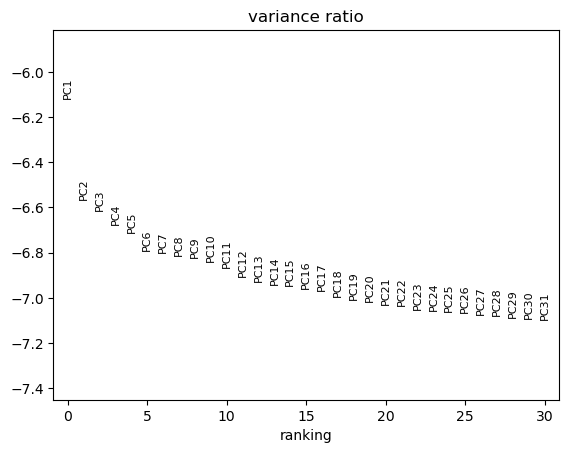

In [179]:
sc.pp.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True)

In [180]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

In [181]:
sc.tl.umap(adata)

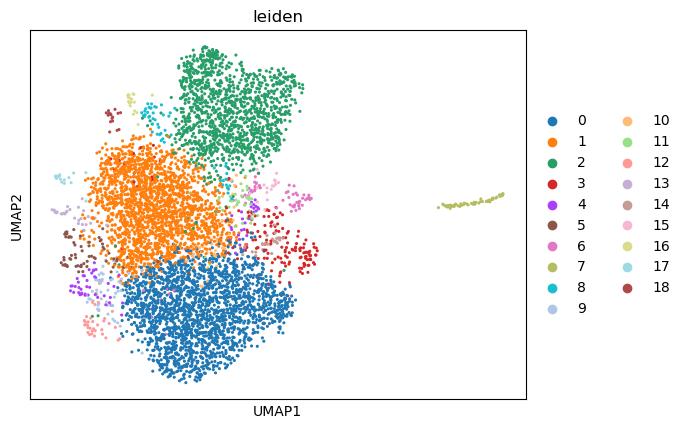

In [182]:
sc.tl.leiden(adata, resolution=0.5)  # Adjust resolution for granularity
sc.pl.umap(adata, color="leiden")  # Visualize clusters

In [183]:
marker_genes_dict =  [ "SIAH1", "PRIM2", "DYNC1H1", "SIRT1", "PPP1CA", "PDE6D", "YWHAZ", "FBXO42", "CHMP5", 
    "SNRPB", "CRK", "TREH",  "UQCRC2", "PUM2", "SNRPD2", "CCT5", "KAT5", "LYN", 
    "PRKCE", "HAGH", "DNAJA1", "DNAJA2", "SNCA", "TH", "KIT", "KITLG", "NR4A2"]

sc.pl.dotplot(adata, marker_genes_dict, "leiden", dendrogram=True)

ValueError: Incompatible observations. Dendrogram data has 12 categories but current groupby observation ['leiden'] contains 19 categories. Most likely the underlying groupby observation changed after the initial computation of `sc.tl.dendrogram`. Please run `sc.tl.dendrogram` again.'

In [ ]:
# List of gene markers for midbrain dopaminergic neurons in scRNA-seq analysis
gene_markers = [
    "TH",        # Tyrosine Hydroxylase: key enzyme in dopamine synthesis
    "DDC",       # Aromatic L-Amino Acid Decarboxylase (AADC): converts L-DOPA to dopamine
    "SLC18A2",   # VMAT2: packages dopamine into synaptic vesicles
    #"SLC6A3",    # DAT: dopamine transporter for reuptake of dopamine
    "NR4A2",     # NURR1: nuclear receptor essential for mDA neuron differentiation
    #"PITX3",     # Pituitary homeobox 3: important for mDA neuron maturation and survival
    #"LMX1A",     # LIM homeobox transcription factor 1 alpha: specifies mDA lineage
    "LMX1B",     # LIM homeobox transcription factor 1 beta: involved in mDA neuron development
    #"FOXA2",     # Forkhead box A2: indicates ventral midbrain (floor plate) identity
    "EN1",       # Engrailed 1: midbrain marker involved in mDA development
    "EN2",       # Engrailed 2: midbrain marker involved in mDA development
    #"OTX2",      # Orthodenticle homeobox 2: involved in midbrain patterning
    "KCNJ6",     # GIRK2: marker enriched in substantia nigra-like dopaminergic neurons
    "CALB1",     # Calbindin: marker more common in ventral tegmental area (VTA)-like neurons
    "GFAP", "MAP2", "RBFOX3", "NES"
    
]

print(gene_markers)

In [ ]:
sc.pl.dotplot(adata, gene_markers, "leiden", dendrogram=True)

In [ ]:
adata

In [ ]:
adata.write("../data/organoids_SCT.h5ad")

In [ ]:
adata_hvg = adata[:, adata.var["highly_variable"]]

In [ ]:
adata_hvg.write("../data/organoids_SCT_hvg.h5ad")

In [ ]:
adata_hvg

In [ ]:
marker_genes_dict_2 = ['PRIM2', 'PPP1CA', 'PDE6D', 'FBXO42', 'CRK', 'PRKCE', 'HAGH', 'SNCA', 'KITLG']

In [ ]:
sc.pl.dotplot(adata_hvg, marker_genes_dict_2, "leiden", dendrogram=True)

# Sandbox

In [ ]:
adata

## 1. Visualizing Raw vs. Normalized Expression

## Raw Counts

- The raw counts often exhibit large variability, with some genes having very high expression levels compared to others.
- This variability is visible in the violin plots, where some genes have broader distributions with higher medians.

## Square-root Normalization

- Applying the square root transformation reduces the influence of large outliers and compresses the dynamic range of the data.
- As a result, the distributions across genes become more similar, and the mean values appear closer together.
- This transformation preserves the relative differences between low- and high-expression values but makes the data less skewed.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set seed for reproducibility
np.random.seed(42)

# Ensure HVG exists
if "highly_variable" in adata.var.columns:
    hvg_genes = adata.var.index[adata.var["highly_variable"]].tolist()
else:
    hvg_genes = adata.var_names.tolist()

# Select 10 random highly variable genes
random_genes = np.random.choice(hvg_genes, 10, replace=False)

# Convert sparse matrix to dense and create DataFrame
raw_counts = pd.DataFrame(adata[:, random_genes].layers["raw"].toarray(), columns=random_genes)

# Plot raw counts
plt.figure(figsize=(12, 6))
sns.violinplot(data=raw_counts, inner="quartile")
plt.xticks(rotation=90)
plt.title("Raw Counts Distribution (10 Random Highly Variable Genes)")
plt.xlabel("Genes")
plt.ylabel("Raw Counts")
plt.show()

# Convert sparse matrix to dense for sqrt-normalized counts
sqrt_norm_counts = pd.DataFrame(adata[:, random_genes].layers["sqrt_norm"].toarray(), columns=random_genes)

# Plot sqrt-normalized counts
plt.figure(figsize=(12, 6))
sns.violinplot(data=sqrt_norm_counts, inner="quartile")
plt.xticks(rotation=90)
plt.title("Square-root Normalized Counts Distribution (10 Random Highly Variable Genes)")
plt.xlabel("Genes")
plt.ylabel("Normalized Counts (sqrt)")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Check if mean expression exists in `adata.var`, otherwise compute it
if "vst.mean" in adata.var.columns:
    top_mean_genes = adata.var["vst.mean"].nlargest(10).index.tolist()
else:
    # Compute mean expression manually if not available
    mean_expression = adata.X.mean(axis=0).A1 if hasattr(adata.X, "A1") else adata.X.mean(axis=0)
    adata.var["mean_expression"] = mean_expression
    top_mean_genes = adata.var["mean_expression"].nlargest(10).index.tolist()

# Convert sparse matrix to dense and create DataFrame
raw_counts_top = pd.DataFrame(adata[:, top_mean_genes].layers["raw"].toarray(), columns=top_mean_genes)

# Plot raw counts for high mean expression genes
plt.figure(figsize=(12, 6))
sns.violinplot(data=raw_counts_top, inner="quartile")
plt.xticks(rotation=90)
plt.title("Raw Counts Distribution (Top 10 Genes by Mean Expression)")
plt.xlabel("Genes")
plt.ylabel("Raw Counts")
plt.show()

# Convert sparse matrix to dense for sqrt-normalized counts
sqrt_norm_counts_top = pd.DataFrame(adata[:, top_mean_genes].layers["sqrt_norm"].toarray(), columns=top_mean_genes)

# Plot sqrt-normalized counts
plt.figure(figsize=(12, 6))
sns.violinplot(data=sqrt_norm_counts_top, inner="quartile")
plt.xticks(rotation=90)
plt.title("Square-root Normalized Counts Distribution (Top 10 Genes by Mean Expression)")
plt.xlabel("Genes")
plt.ylabel("Normalized Counts (sqrt)")
plt.show()


## 2. Mean-Variance Relationship Before & After Normalization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 📌 Convert sparse matrices to dense only if necessary
X_raw = adata.layers["raw"]
X_sqrt = adata.layers["sqrt_norm"]
X_pearson = adata.layers["pearson_residuals"]

if hasattr(X_raw, "toarray"):  # Check if it's sparse
    X_raw = X_raw.toarray()
if hasattr(X_sqrt, "toarray"):  
    X_sqrt = X_sqrt.toarray()
if hasattr(X_pearson, "toarray"):  
    X_pearson = X_pearson.toarray()

# 📌 Compute mean and variance
adata.var["mean_raw"] = np.mean(X_raw, axis=0)
adata.var["var_raw"] = np.var(X_raw, axis=0)

adata.var["mean_sqrt"] = np.mean(X_sqrt, axis=0)
adata.var["var_sqrt"] = np.var(X_sqrt, axis=0)

adata.var["mean_pearson"] = np.mean(X_pearson, axis=0)
adata.var["var_pearson"] = np.var(X_pearson, axis=0)

# 📌 Scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, mean, var, title in zip(
    axes, 
    ["mean_raw", "mean_sqrt", "mean_pearson"], 
    ["var_raw", "var_sqrt", "var_pearson"],
    ["Raw Counts", "Square-root Normalized", "Pearson Residuals"]
):
    ax.scatter(adata.var[mean], adata.var[var], s=3, alpha=0.5)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"Mean-Variance Relationship ({title})")
    ax.set_xlabel("Mean expression")
    ax.set_ylabel("Variance")

plt.tight_layout()
plt.show()

### **Mean-Variance Relationship Plots: Interpretation**

The plots compare the relationship between the **mean expression** and the **variance** of genes across three data transformations: 

1. **Raw Counts**
2. **Square-root Normalized Counts**
3. **Pearson Residuals**

---

## **1️⃣ Raw Counts**
- **Trend:** Variance increases with the mean expression.
- **Key Observations:**
  - Highly expressed genes exhibit higher variability.
  - Lowly expressed genes show low variance but may be dominated by dropout effects.
- **Why it happens:** The raw count data is heavily affected by technical noise and biological variability, leading to strong **mean-variance dependency**.
- **Limitations:**
  - Not variance-stabilized.
  - Unsuitable for direct downstream analyses like clustering or differential expression.

---

## **2️⃣ Square-root Normalized Counts**
- **Trend:** The variance is reduced but still slightly dependent on the mean.
- **Key Observations:**
  - Square-root transformation compresses highly variable genes, making their variability less extreme.
  - Low-expression genes remain largely unaffected.
- **Why it happens:** Square-root normalization adjusts the scale of the data, reducing the impact of high expression values but does not fully remove systematic variance trends.
- **Strengths:**
  - Improves variance stabilization.
  - Useful for moderate adjustments.
- **Limitations:**
  - Still retains some mean-variance dependency, which may bias downstream results.

---

## **3️⃣ Pearson Residuals**
- **Trend:** Variance is independent of the mean, centered around **variance = 1**.
- **Key Observations:**
  - Most genes have residual variance ≈ 1, which corresponds to the null model (no biological variability).
  - Genes with **residual variance > 1** deviate from the null model and may represent **highly variable genes (HVGs)**.
- **Why it happens:** Pearson residuals are calculated by subtracting expected counts (null model) from observed counts and scaling by their standard deviation, stabilizing variance.
- **Strengths:**
  - Fully variance-stabilized.
  - Highlights **biologically variable genes**.
- **Use Case:**
  - Identify HVGs for clustering, differential expression, or pathway analysis.

---

### **Key Takeaways**
- **Raw Counts:** Strong mean-variance dependency; not ideal for direct use.
- **Square-root Normalized Counts:** Partially stabilizes variance but retains dependency.
- **Pearson Residuals:** Achieves full variance stabilization and highlights biologically meaningful variability.

---

### **Additional Notes**
- Pearson residuals are particularly useful in identifying genes that deviate significantly from technical noise, making them suitable for **unsupervised analyses**.
- This approach is commonly recommended for scRNA-seq preprocessing because it ensures robust downstream results.


## 3. Residual Variance vs. Mean Expression (Pearson Residuals)

In [ ]:
# Extract mean and residual variances
mean_counts = adata.var["mean_counts"]
residual_variances = adata.var["residual_variances"]
hvgs = adata.var["highly_variable"]

# Scatter plot of residual variance vs. mean expression
plt.figure(figsize=(6, 4))
plt.scatter(mean_counts, residual_variances, s=3, edgecolor="none", label="All genes")
plt.scatter(mean_counts[hvgs], residual_variances[hvgs], c="tab:red", s=3, edgecolor="none", label="HVGs")

# Add reference line (expected variance = 1)
plt.axhline(y=1, color="black", linestyle="--", label="Null Model Variance = 1")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean expression")
plt.ylabel("Residual variance")
plt.title("Highly Variable Genes (Pearson Residuals)")
plt.legend()
plt.show()

## 4. Compare HVG Selection: Pearson vs. Seurat

In [ ]:
pip install matplotlib-venn

In [ ]:
from matplotlib_venn import venn2

# Compute HVGs using Seurat flavor with raw counts
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="raw"  # Specify raw count layer
)
hvg_seurat = set(adata.var_names[adata.var["highly_variable"]])

# # Compute HVGs using Pearson residuals
# sc.experimental.pp.highly_variable_genes(
#     adata,
#     flavor="pearson_residuals",
#     n_top_genes=2000
# )
# hvg_pearson = set(adata.var_names[adata.var["highly_variable"]])

# # Plot Venn diagram
# plt.figure(figsize=(4, 4))
# venn2([hvg_seurat, hvg_pearson], set_labels=("Seurat HVGs", "Pearson Residuals HVGs"))
# plt.title("HVG Selection Methods Comparison")
# plt.show()

### **Highly Variable Gene (HVG) Calculation: Seurat vs Pearson Residuals**

In single-cell RNA-seq analysis, identifying **highly variable genes (HVGs)** is a crucial step. Different methods, such as **Seurat V3 flavor** and **Pearson residuals**, employ distinct strategies for identifying HVGs, which often results in **limited overlap between the two methods**.

---

### **How Seurat and Pearson Residuals Calculate HVGs**

### **1️⃣ Seurat V3 Flavor**
- **Purpose:** Identifies HVGs based on raw count data.
- **Steps:**
  1. Calculates **mean expression** and **dispersion (variance/mean)** for each gene.
  2. Fits a **loess regression** to model the relationship between mean expression and dispersion.
  3. Selects genes with the highest **residual dispersion** (above the fitted curve).
- **Strengths:**
  - Specifically optimized for raw count data.
  - Suitable for identifying highly dispersed genes.
- **Limitations:**
  - Assumes variance follows a specific distribution, which might not hold for all datasets.
  - Requires raw integer count data.

---

### **2️⃣ Pearson Residuals**
- **Purpose:** Identifies HVGs using a variance-stabilized approach.
- **Steps:**
  1. Computes a **null model** of expected counts, assuming no biological variability.
  2. Calculates **Pearson residuals**: 
     \[
     \text{Residual} = \frac{\text{Observed} - \text{Expected}}{\sqrt{\text{Expected}}}
     \]
  3. Selects genes with **residual variance > 1** (indicating biological variability).
- **Strengths:**
  - Stabilizes variance across genes.
  - More robust to technical noise and systematic biases.
- **Limitations:**
  - Requires normalized or preprocessed data.

---

### **Why Do Seurat and Pearson Residuals Have Limited Overlap?**

1. **Different Data Requirements:**
   - Seurat requires **raw integer counts**, while Pearson residuals operate on **normalized/preprocessed data**.
   - This difference inherently affects the list of identified HVGs.

2. **Statistical Framework:**
   - Seurat focuses on **dispersion** relative to the mean, selecting genes with the highest residual dispersion.
   - Pearson residuals use a **variance-stabilized null model**, identifying genes with variability beyond expected noise.

3. **Focus of Each Method:**
   - Seurat is **more sensitive to highly expressed genes** with large variance.
   - Pearson residuals are better at highlighting **biologically variable genes**, even among lowly expressed genes.

4. **Biological Context:**
   - Seurat tends to identify genes with **large technical variance** or high dropout, while Pearson residuals prioritize **genes with true biological variability**.

---

### **Key Takeaways**
- **Overlap is Small:** The limited overlap reflects the distinct statistical approaches and data requirements of the methods.
- **Complementary Use:** Combining both methods can provide a more comprehensive set of HVGs for downstream analyses, balancing sensitivity to technical and biological variability.
- **Best Practice:** Choose the method that aligns with the data type (raw or normalized) and the goal of the analysis (e.g., technical variability vs. biological variability).

---

### **Next Steps**
- Use **Seurat** when working with raw count data to identify genes with the largest dispersion.
- Use **Pearson residuals** for normalized data to detect genes with true biological variability.
- Consider combining the two methods to capture both technical and biological variability.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute HVGs using Seurat V3 flavor
# Recompute HVGs using Seurat V3 flavor
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="raw"  # Ensure raw counts are used
)

In [ ]:
print(adata.layers["raw"])  # Ensure raw counts layer exists
print(adata.layers["raw"].dtype)  # Should be integers


In [ ]:
print(adata.var.columns)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract relevant data
mean = adata.var["means"]  # Mean expression
dispersion = adata.var["variances"]  # Observed dispersion
dispersion_fit = adata.var["variances_norm"]  # Fitted dispersion trend
hvg_mask = adata.var["highly_variable"]  # Mask for HVGs

# Plot mean-dispersion relationship
plt.figure(figsize=(8, 6))
sns.scatterplot(x=mean, y=dispersion, s=5, alpha=0.5, label="All Genes")
sns.lineplot(x=mean, y=dispersion_fit, color="red", label="Fitted Trend", lw=2)
sns.scatterplot(x=mean[hvg_mask], y=dispersion[hvg_mask], color="tab:red", s=10, label="HVGs")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean Expression")
plt.ylabel("Dispersion")
plt.title("Mean-Dispersion Relationship (Seurat V3 HVG Selection)")
plt.legend()
plt.tight_layout()
plt.show()


### **Mean-Dispersion Relationship: Seurat V3 HVG Selection**

The plot visualizes the relationship between **mean expression** and **dispersion** (variance normalized by mean) for all genes in the dataset. It illustrates how Seurat V3 selects **highly variable genes (HVGs)** based on their dispersion relative to a fitted trend.

---

### **Key Elements of the Plot**

1. **Blue Dots (All Genes):**
   - Represent all genes in the dataset.
   - Show the observed dispersion values across a range of mean expression levels.
   - Dispersion decreases as mean expression increases due to technical effects and mean-variance dependency.

2. **Red Line (Fitted Trend):**
   - Represents the **expected dispersion** for genes at each mean expression level.
   - The line is computed using a **LOESS regression**, capturing the mean-variance trend.
   - This trend separates genes with expected variability from those with excess variability.

3. **Red Dots (HVGs):**
   - Highlight genes classified as **highly variable genes (HVGs)**.
   - HVGs are outliers with **dispersion values significantly above the fitted trend**.
   - These genes likely exhibit true biological variability and are candidates for further analysis.

---

### **What Does This Plot Explain?**

- **HVG Selection Process:**
  - Seurat V3 identifies genes with higher-than-expected variability relative to the fitted trend.
  - The selection accounts for mean expression, ensuring fair comparisons between genes with different expression levels.

- **Biological Insight:**
  - HVGs are more likely to represent biologically relevant variability, such as differences in gene expression across cell types or conditions.

---

### **Interpretation and Use Cases**

1. **Validation of HVG Selection:**
   - Ensure that the fitted trend (red line) accurately models the mean-variance dependency.
   - Confirm that selected HVGs (red dots) are appropriate outliers.

2. **Downstream Analyses:**
   - Use the identified HVGs for tasks like:
     - **Clustering**: HVGs drive separation of cell types.
     - **Differential Expression Analysis**: Focus on biologically relevant genes.
     - **Pathway Enrichment**: Analyze the pathways enriched in HVGs.

---

### **Suggestions for Refinement**

- **Add Gene Annotations:**
  - Highlight specific HVGs of interest (e.g., known markers or genes with biological significance).

- **Color HVGs by Metadata:**
  - If you have metadata (e.g., cell type or condition labels), color-code HVGs to visualize biological trends.

- **Compare with Other HVG Methods:**
  - Generate similar plots for Pearson residuals or other methods to understand differences in HVG selection.

---

This plot provides a clear visualization of how Seurat V3 identifies biologically variable genes, making it a key step in single-cell RNA-seq preprocessing and analysis.


In [ ]:
# Identify top-5 HVGs for each case
top5_common_hvgs = list(hvg_seurat.intersection(hvg_pearson))[:5]  # Shared HVGs
top5_seurat_only_hvgs = list(hvg_seurat.difference(hvg_pearson))[:5]  # Seurat-only HVGs
top5_pearson_only_hvgs = list(hvg_pearson.difference(hvg_seurat))[:5]  # Pearson-only HVGs


In [ ]:
# Extract data for Seurat V3
mean_seurat = adata.var["means"]
dispersion_seurat = adata.var["variances"]
dispersion_fit_seurat = adata.var["variances_norm"]
hvg_seurat_mask = adata.var["highly_variable"]

# Seurat V3 mean-dispersion plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=mean_seurat, y=dispersion_seurat, s=5, alpha=0.5, label="All Genes")
sns.lineplot(x=mean_seurat, y=dispersion_fit_seurat, color="red", label="Fitted Trend", lw=2)
sns.scatterplot(x=mean_seurat[hvg_seurat_mask], y=dispersion_seurat[hvg_seurat_mask], color="tab:red", label="HVGs (Seurat)", s=10)

# Highlight top-5 genes in each case
for gene in top5_common_hvgs:
    idx = adata.var_names.get_loc(gene)
    plt.scatter(mean_seurat[idx], dispersion_seurat[idx], color="blue", label=f"{gene} (Both HVG)", s=100, edgecolor="black")
for gene in top5_seurat_only_hvgs:
    idx = adata.var_names.get_loc(gene)
    plt.scatter(mean_seurat[idx], dispersion_seurat[idx], color="green", label=f"{gene} (Seurat-only HVG)", s=100, edgecolor="black")

# Formatting
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean Expression")
plt.ylabel("Dispersion")
plt.title("Mean-Dispersion Relationship (Seurat V3 HVG Selection)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Adjust legend position
plt.tight_layout()
plt.show()


In [ ]:
# Extract mean and residual variances for Pearson
mean_counts = adata.var["mean_counts"]
residual_variances = adata.var["residual_variances"]
hvg_pearson_mask = adata.var["highly_variable"]

# Scatter plot for Pearson Residuals
plt.figure(figsize=(8, 6))
plt.scatter(mean_counts, residual_variances, s=3, edgecolor="none", label="All Genes")
plt.scatter(mean_counts[hvg_pearson_mask], residual_variances[hvg_pearson_mask], c="tab:red", s=10, edgecolor="none", label="HVGs (Pearson)")

# Highlight top-5 genes in each case
for gene in top5_common_hvgs:
    idx = adata.var_names.get_loc(gene)
    plt.scatter(mean_counts[idx], residual_variances[idx], color="blue", label=f"{gene} (Both HVG)", s=100, edgecolor="black")
for gene in top5_pearson_only_hvgs:
    idx = adata.var_names.get_loc(gene)
    plt.scatter(mean_counts[idx], residual_variances[idx], color="purple", label=f"{gene} (Pearson-only HVG)", s=100, edgecolor="black")

# Add reference line (expected variance = 1)
plt.axhline(y=1, color="black", linestyle="--", label="Null Model Variance = 1")

# Formatting
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean Expression")
plt.ylabel("Residual Variance")
plt.title("Highly Variable Genes (Pearson Residuals)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Adjust legend position
plt.tight_layout()
plt.show()


In [ ]:
# Check HVG membership
seurat_hvg_status = {gene: gene in hvg_seurat for gene in marker_genes_dict}
pearson_hvg_status = {gene: gene in hvg_pearson for gene in marker_genes_dict}

# Create a DataFrame to summarize results
import pandas as pd
hvg_results = pd.DataFrame({
    "Gene": marker_genes_dict,
    "Seurat_V3_HVG": [seurat_hvg_status[gene] for gene in marker_genes_dict],
    "Pearson_HVG": [pearson_hvg_status[gene] for gene in marker_genes_dict],
})

# Print for debugging (optional)
print(hvg_results)

## 5. UMAP Before vs. After Normalization

In [ ]:
sc.pp.pca(adata, layer="raw")
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)
sc.pl.umap(adata, color="leiden", title="UMAP (Raw Counts)")

sc.pp.pca(adata, layer="pearson_residuals")
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)
sc.pl.umap(adata, color="leiden", title="UMAP (Pearson Residuals)")